# HW1-3: Generalization

In [ ]:
###############################################
#########    Deep Learning            #########
#########    Pedram MohajerAnsari     #########
#########    Homework 1 - Part 3      #########
###############################################

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
pwd

'/content/drive/MyDrive/Deep_Learning_HW1/P1'

In [ ]:
############################################
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
TORCH_CUDA_ARCH_LIST="8.6"
############################################
import torch
import torchvision
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torch.backends.cudnn   as cudnn
from   sklearn.decomposition  import PCA
from   mpl_toolkits.mplot3d   import Axes3D
import torchvision.transforms.functional as TF
import torchvision.transforms as transformtransforms

############################################
from torchvision  import models
from torchsummary import summary
from torchvision  import transforms
############################################
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
from tqdm import tqdm
############################################
import cv2
import copy
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from   PIL import Image
from   glob import glob
############################################

In [ ]:
############################################
Project_PATH = os.path.dirname(os.path.abspath('__file__'))
outputs_dir = Project_PATH + '/'
model_path  = Project_PATH + '/save_models/'
############################################

In [ ]:
############################################
print('Is CUDA available : ',torch.cuda.is_available())
############################################
print('Device Count      : ',torch.cuda.device_count())
############################################
print('Currrent Device   : ',torch.cuda.current_device())
############################################
device_default = torch.cuda.current_device()
torch.cuda.device(device_default)
print('Default Device    : ',torch.cuda.get_device_name(device_default))
############################################
device = torch.device("cuda")
print('Cude Version      : ',torch.version.cuda)
############################################
print('Torch Version     : ',torch.__version__)
############################################
print(torch.cuda.get_arch_list())
############################################

Is CUDA available :  True
Device Count      :  1
Currrent Device   :  0
Default Device    :  Tesla T4
Cude Version      :  11.6
Torch Version     :  1.13.1+cu116
['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']


In [ ]:
############################################
class DNN_MNIST_4_layer(nn.Module):
    def __init__(self, in_dim, hidden_1, hidden_2, hidden_3, out_dim):
        super(DNN_MNIST_4_layer, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, hidden_1),nn.BatchNorm1d(hidden_1),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(hidden_1, hidden_2),nn.BatchNorm1d(hidden_2),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(hidden_2, hidden_3),nn.BatchNorm1d(hidden_3),nn.ReLU(True))
        self.layer4 = nn.Sequential(nn.Linear(hidden_3, out_dim))
        
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x)    
        x = self.layer4(x)
        return x
        
############################################
class DNN_MNIST_5_layer(nn.Module):
    def __init__(self):
        super(DNN_MNIST_5_layer, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(28*28, 256),nn.BatchNorm1d(256),nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(256, 128),nn.BatchNorm1d(128),nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(128, 64),nn.BatchNorm1d(64),nn.ReLU(True))
        self.layer4 = nn.Sequential(nn.Linear(64, 32),nn.BatchNorm1d(32),nn.ReLU(True))
        self.layer5 = nn.Sequential(nn.Linear(32, 10))
        
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)    
        x = self.layer3(x)    
        x = self.layer4(x)    
        x = self.layer5(x)    
        return x
    
############################################

In [ ]:
############################################

def standardization(x):
    x = np.array(x)
    x[np.isnan(x)] = 0
    return (x-np.mean(x)) / np.std(x)
  
############################################

## Can network fit random labels?

In [ ]:

#### Define train function ####

def train_shuffle(model_name, Epochs = 100, Batch  = 2000, Data_workers = 0, LR = 0.01):
    
    #### Initiate data ####

    trainset = torchvision.datasets.MNIST(root='./data/', train=True, download=True,  transform=transforms.ToTensor())
    testset = torchvision.datasets.MNIST(root='./data/',  train=False, download=True, transform=transforms.ToTensor())
    
    #### Shuffle labels ####

    random.shuffle(trainset.train_labels)
    trainloader = DataLoader(trainset, batch_size=Batch, shuffle=True, num_workers=Data_workers)
    testloader  = DataLoader(testset,  batch_size=Batch, shuffle=True, num_workers=Data_workers)

    print("Dataset Information : ")
    print(trainset.classes)
    print(trainset.data.shape)
    print(testset.data.shape)
    
    #### Initiate model ####

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
    Model  = model_name.to(device)

    #### loss & optimizer ####

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(Model.parameters(), lr=LR, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.8)

    #### Training ####

    trainloss_list = []
    testloss_list  = []
    accuracy_list  = []
    lr_list        = []
   
    for epoch in range(Epochs):

        Model.train()
        train_loss = 0.0

        for i, data in enumerate(trainloader):
            images, labels = data
            images  = (images.view(-1, 28*28)).to(device)
            labels  = labels.to(device)
            outputs = Model(images)
            loss    = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total       = (i+1)*Batch

        #### Evaluating ####
        
        Model.eval()
        with torch.no_grad():
            test_loss = 0
            correct = 0
            total = 0
            for data in testloader:
                images, labels = data
                images  = (images.view(-1, 28*28)).to(device)
                labels  = labels.to(device)
                outputs = Model(images)
                loss    = criterion(outputs, labels)
                test_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                correct += (pred == labels).cpu().sum()
                total += labels.size(0)
            total = len(testloader.dataset)
            accuracy = 100.0*correct/total

        #### Save loss ####

        scheduler.step()
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        trainloss_list.append(train_loss)
        testloss_list.append(test_loss)
        accuracy_list.append(accuracy)
        print('{}/{} Test set: Average loss: {:.4f}/{:.4f}, Accuracy: {}/{} ({:.2f}%) lr={}'.format(epoch, Epochs, train_loss, test_loss, correct, total, accuracy, lr_list[-1]))

    return [trainloss_list, testloss_list, accuracy_list, lr_list]

####################################################################################################
[trainloss_list, testloss_list, accuracy_list, lr_list] = train_shuffle(model_name=DNN_MNIST_5_layer())

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Dataset Information : 
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
0/100 Test set: Average loss: 70.4569/11.5026, Accuracy: 1274/10000 (12.74%) lr=0.01
1/100 Test set: Average loss: 68.9404/11.5454, Accuracy: 1145/10000 (11.45%) lr=0.01
2/100 Test set: Average loss: 68.4283/11.5464, Accuracy: 1205/10000 (12.05%) lr=0.01
3/100 Test set: Average loss: 68.0492/11.5973, Accuracy: 1136/10000 (11.36%) lr=0.01
4/100 Test set: Average loss: 67.6815/11.6194, Accuracy: 1096/10000 (10.96%) lr=0.008
5/100 Test set: Average loss: 67.2590/11.6275, Accuracy: 1101/10000 (11.01%) lr=0.008
6/100 Test set: Average loss: 66.9179/11.6114, Accuracy: 1129/10000 (11.29%) lr=0.008
7/100 Test set: Average loss: 66.5460/11.7160, Accuracy: 989/10000 (9.89%) lr=0.008
8/100 Test set: Average loss: 66.1500/11.7395, Accuracy: 955/10000 (9.55%) lr=0.008
9/100 Test set: Average loss: 65.7

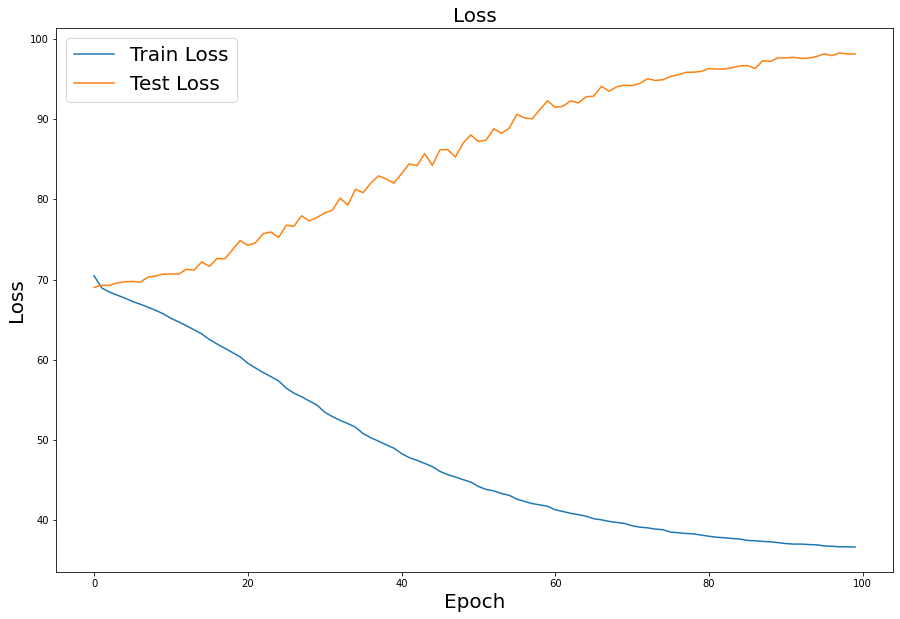

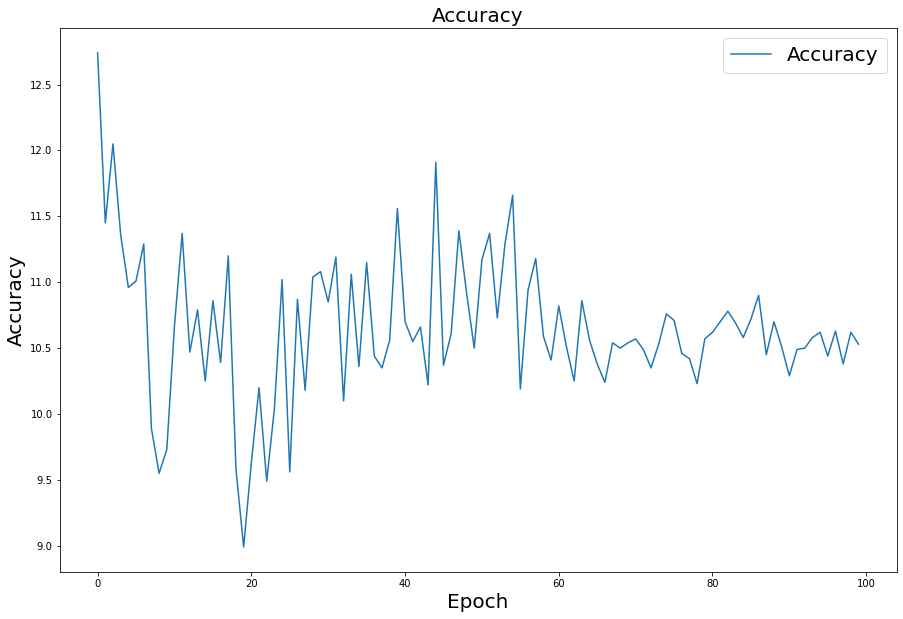

In [ ]:
########################################################################################
def plotting():
  plt.figure(figsize=(15,10))
  plt.plot(np.array(trainloss_list), label='Train Loss')
  plt.plot(np.array(testloss_list)*6, label='Test Loss')
  plt.xlabel('Epoch',fontsize=20)
  plt.ylabel('Loss',fontsize=20)
  plt.title('Loss',fontsize=20)
  plt.legend(fontsize=20)
  plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_3/img0.png')
  plt.show()

  plt.figure(figsize=(15,10))
  plt.plot(accuracy_list, label='Accuracy')
  plt.xlabel('Epoch',fontsize=20)
  plt.ylabel('Accuracy',fontsize=20)
  plt.title('Accuracy',fontsize=20)
  plt.legend(fontsize=20)
  plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_3/img1.png')
  plt.show()

########################################################################################
plotting()

## Number of parameters v.s. Generalization

In [ ]:
def train_CIFAR10(model_name, Epochs=20, Batch=2000, Data_workers=0, LR=0.1):

    #### Load datasets ####
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data/',train=True,download=True,transform=transform)
    testset = torchvision.datasets.CIFAR10(root='./data/',train=False,download=True,transform=transform)
    trainloader = DataLoader(trainset, batch_size=Batch, shuffle=True, num_workers=Data_workers)
    testloader  = DataLoader(testset,  batch_size=Batch, shuffle=True, num_workers=Data_workers)
    
    print("Dataset Information : ")
    print(trainset.classes)
    print(trainset.data.shape)
    print(testset.data.shape)
    

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    Model = model_name.to(device)

    number_of_param = sum(param.numel() for param in Model.parameters())
    
    print(model_name)
    print('Number of total parameters: ', number_of_param)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(Model.parameters(), lr=LR, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.8)

    #### Training ####
    
    trainloss_list = []
    testloss_list  = []
    train_acc_list = []
    test_acc_list  = []
    lr_list        = []
    
    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for i, data in enumerate(trainloader):
            images, labels = data
            images = (images.view(-1, 3*32*32)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            train_correct += (pred == labels).cpu().sum()
        train_total = len(trainloader.dataset)
        train_acc = 100.0*train_correct/train_total

        #### Evaluating ####

        Model.eval()
        with torch.no_grad():
            test_loss = 0
            test_correct = 0
            test_total = 0
            for data in testloader:
                images, labels = data
                images = (images.view(-1, 3*32*32)).to(device)
                labels = labels.to(device)
                outputs = Model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                test_correct += (pred == labels).cpu().sum()
            test_total = len(testloader.dataset)
            test_acc = 100.0*test_correct/test_total

        #### Save loss ####

        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        trainloss_list.append(train_loss)
        testloss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('{}/{} Test set: Average loss: {:.4f}/{:.4f}, Accuracy: {}/{} ({:.2f}%)/({:.2f}%) lr={}'.format(epoch, Epochs, train_loss,test_loss, train_correct,test_correct, train_acc,test_acc, lr_list[-1]))

    return [trainloss_list, testloss_list, train_acc_list, test_acc_list, lr_list, number_of_param]
    


In [ ]:
####################################################################################
[trainloss_1,testloss_1,train_acc_1,test_acc_1,_,num_param_1]      = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,1,2,1,10),Epochs=100)
####################################################################################
[trainloss_2,testloss_2,train_acc_2,test_acc_2,_,num_param_2]      = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,2,4,2,10),Epochs=100)
####################################################################################
[trainloss_3,testloss_3,train_acc_3,test_acc_3,_,num_param_3]      = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,3,6,3,10),Epochs=100)
####################################################################################
[trainloss_4,testloss_4,train_acc_4,test_acc_4,_,num_param_4]      = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,5,10,5,10),Epochs=100)
####################################################################################
[trainloss_5,testloss_5,train_acc_5,test_acc_5,_,num_param_5]      = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,10,20,10,10),Epochs=100)
####################################################################################
[trainloss_6,testloss_6,train_acc_6,test_acc_6,_,num_param_6]      = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,20,40,20,10),Epochs=100)
####################################################################################
[trainloss_7,testloss_7,train_acc_7,test_acc_7,_,num_param_7]      = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,50,100,50,10),Epochs=100)
####################################################################################s
[trainloss_8,testloss_8,train_acc_8,test_acc_8,_,num_param_8]      = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,100,200,100,10),Epochs=100)
####################################################################################
[trainloss_9,testloss_9,train_acc_9,test_acc_9,_,num_param_9]      = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,200,400,200,10),Epochs=100)
####################################################################################
[trainloss_10,testloss_10,train_acc_10,test_acc_10,_,num_param_10] = train_CIFAR10(model_name=DNN_MNIST_4_layer(3*32*32,500,1000,500,10),Epochs=100)
####################################################################################

Files already downloaded and verified
Files already downloaded and verified
Dataset Information : 
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 32, 32, 3)
(10000, 32, 32, 3)
DNN_MNIST_4_layer(
  (layer1): Sequential(
    (0): Linear(in_features=3072, out_features=1, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
  )
)
Number of total parameters:  3108
0/100 Test set: Avera

In [ ]:
################################################################################################
num_param_list = [num_param_1,num_param_2,num_param_3,num_param_4,num_param_5,num_param_6,num_param_7,num_param_8,num_param_9,num_param_10]
################################################################################################
trainloss_list = [trainloss_1,trainloss_2,trainloss_3,trainloss_4,trainloss_5,trainloss_6,trainloss_7,trainloss_8,trainloss_9,trainloss_10]
trainloss      = np.array(trainloss_list)[:,-1]
testloss_list  = [testloss_1,testloss_2,testloss_3,testloss_4,testloss_5,testloss_6,testloss_7,testloss_8,testloss_9,testloss_10]
testloss       = np.array(testloss_list)[:,-1]
################################################################################################
train_acc_list = [train_acc_1,train_acc_2,train_acc_3,train_acc_4,train_acc_5,train_acc_6,train_acc_7,train_acc_8,train_acc_9,train_acc_10]
train_acc      = np.array(train_acc_list)[:,-1]
test_acc_list  = [test_acc_1,test_acc_2,test_acc_3,test_acc_4,test_acc_5,test_acc_6,test_acc_7,test_acc_8,test_acc_9,test_acc_10]
test_acc       = np.array(test_acc_list)[:,-1]
################################################################################################

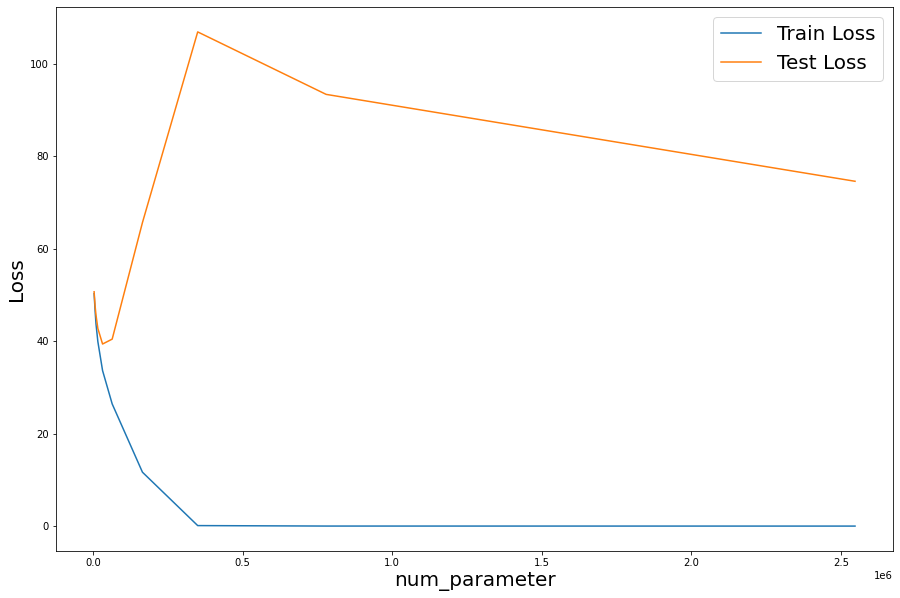

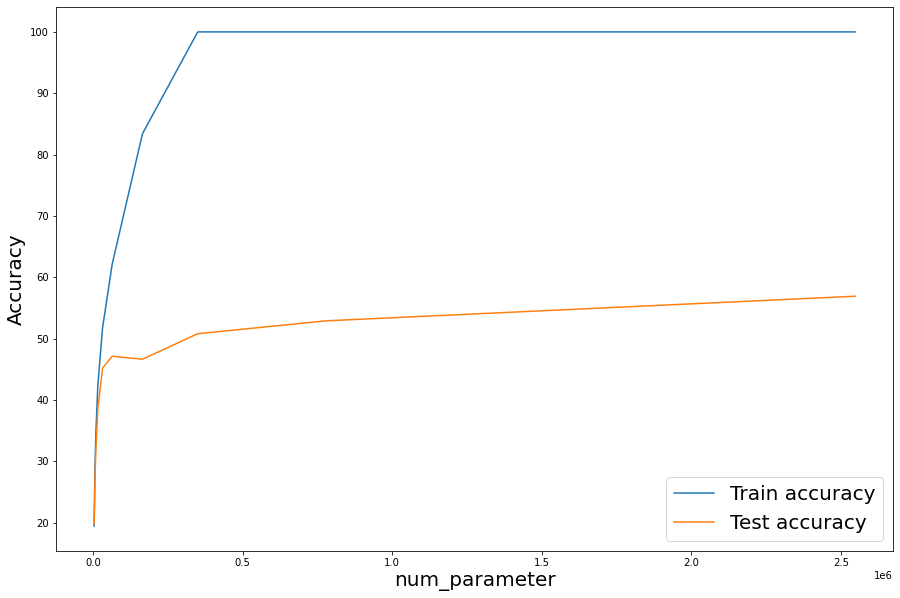

In [ ]:
#### Plot Loss and LR #### 

################################################################################################
plt.figure(figsize=(15,10))
plt.plot((num_param_list), (trainloss), label='Train Loss')
plt.plot((num_param_list), (testloss*5), label='Test Loss')
plt.xlabel('num_parameter',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_3/img2.png')
plt.show()
################################################################################################
plt.figure(figsize=(15,10))
plt.plot(num_param_list, train_acc, label='Train accuracy')
plt.plot(num_param_list, test_acc, label='Test accuracy')
plt.xlabel('num_parameter',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_3/img3.png')
plt.show()
################################################################################################

## Flatness v.s. Generalization - part1

In [ ]:
################################################################################################

def train_MNIST(model_name, Epochs = 20, Batch  = 2000, Data_workers = 0, LR = 0.1):
  
    #### Initiate data ####
    trainset    = torchvision.datasets.MNIST(root='./data/',train=True,download=True,transform=transforms.ToTensor())
    testset     = torchvision.datasets.MNIST(root='./data/',train=False,download=True,transform=transforms.ToTensor())
    trainloader = DataLoader(trainset, batch_size=Batch, shuffle=True, num_workers=Data_workers)
    testloader  = DataLoader(testset,  batch_size=Batch, shuffle=True, num_workers=Data_workers)
    
    print("Datasdet Information : ")
    print(trainset.classes)
    print(trainset.data.shape)
    print(testset.data.shape)

    #### Initiate model ####
    torch.cuda.is_available()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
    Model = model_name.to(device)

    #### loss & optimizer ####
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(Model.parameters(), lr=LR, momentum=0.9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.8)

    #### Training ####
    trainloss_list = []
    testloss_list  = []
    accuracy_list  = []
    lr_list = []
    F = []
   
    for epoch in range(Epochs):
        Model.train()
        train_loss = 0.0
        for i, data in enumerate(trainloader):
            images, labels = data
            images = (images.view(-1, 28*28)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            total = (i+1)*Batch


        #### Evaluating ####

        Model.eval()
        with torch.no_grad():
            test_loss = 0
            correct = 0
            total = 0
            for data in testloader:
                images, labels = data
                images = (images.view(-1, 28*28)).to(device)
                labels = labels.to(device)
                outputs = Model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, pred = torch.max(outputs.data, 1)
                correct += (pred == labels).cpu().sum()
                total += labels.size(0)
            total = len(testloader.dataset)
            accuracy = 100.0*correct/total

        #### Save loss ####

        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        trainloss_list.append(train_loss)
        testloss_list.append(test_loss)
        accuracy_list.append(accuracy)

        print('{}/{} Test set: Average loss: {:.4f}/{:.4f}, Accuracy: {}/{} ({:.2f}%) lr={}'.format(epoch, Epochs, train_loss,test_loss, correct, total, accuracy, lr_list[-1]))

    return [Model, trainloss_list, testloss_list, accuracy_list, lr_list, F]

################################################################################################

### Batch 64 vs 2048

In [ ]:
trainset    = torchvision.datasets.MNIST(root='./data/',train=True,download=True,transform=transforms.ToTensor())
testset     = torchvision.datasets.MNIST(root='./data/',train=False,download=True,transform=transforms.ToTensor())

trainloader = DataLoader(trainset, batch_size=2000, shuffle=True, num_workers=0)
testloader  = DataLoader(testset,  batch_size=2000, shuffle=True, num_workers=0)

device    = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
Model     = DNN_MNIST_4_layer(28*28,100,200,100,10).to(device)
criterion = nn.CrossEntropyLoss()

param_1 = Model_64.state_dict()
param_2 = Model_2048.state_dict()

batch_train_loss = []
batch_test_loss  = []
batch_train_acc  = []
batch_test_acc   = []

alpha_list = np.linspace(-2,2,50)

for i in range(len(alpha_list)):
    alpha     = alpha_list[i]
    param_new = {}

    for key in param_1.keys():
        param_new[key] = (1-alpha)*param_1[key] + alpha*param_2[key]
    
    Model.load_state_dict(param_new)
    Model.eval()
    
    with torch.no_grad():
        train_loss = 0
        correct    = 0
        for data in trainloader:
            images, labels = data
            images  = (images.view(-1, 28*28)).to(device)
            labels  = labels.to(device)
            outputs = Model(images)
            loss    = criterion(outputs, labels)
            
            train_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (pred == labels).cpu().sum()

        total    = len(trainloader.dataset)
        accuracy = 100.0*correct/total
        batch_train_loss.append(loss.detach().cpu().numpy())
        batch_train_acc.append(accuracy.detach().cpu().numpy())
        
        test_loss = 0
        correct   = 0
        
        for data in testloader:
            images, labels = data
            images   = (images.view(-1, 28*28)).to(device)
            labels   = labels.to(device)
            outputs  = Model(images)
            loss     = criterion(outputs, labels)
            test_loss += loss.item()
            _, pred  = torch.max(outputs.data, 1)
            correct += (pred == labels).cpu().sum()

        total    = len(testloader.dataset)
        accuracy = 100.0*correct/total
        batch_test_loss.append(loss.detach().cpu().numpy())
        batch_test_acc.append(accuracy.detach().cpu().numpy())

    print(alpha)

-2.0
-1.9183673469387754
-1.836734693877551
-1.7551020408163265
-1.6734693877551021
-1.5918367346938775
-1.510204081632653
-1.4285714285714286
-1.3469387755102042
-1.2653061224489797
-1.183673469387755
-1.1020408163265307
-1.0204081632653061
-0.9387755102040818
-0.8571428571428572
-0.7755102040816328
-0.6938775510204083
-0.6122448979591837
-0.5306122448979593
-0.44897959183673475
-0.3673469387755104
-0.2857142857142858
-0.20408163265306145
-0.12244897959183687
-0.04081632653061229
0.04081632653061229
0.12244897959183643
0.204081632653061
0.2857142857142856
0.36734693877551017
0.4489795918367343
0.5306122448979589
0.6122448979591835
0.693877551020408
0.7755102040816326
0.8571428571428568
0.9387755102040813
1.020408163265306
1.1020408163265305
1.1836734693877546
1.2653061224489792
1.3469387755102038
1.4285714285714284
1.510204081632653
1.591836734693877
1.6734693877551017
1.7551020408163263
1.8367346938775508
1.9183673469387754
2.0


In [ ]:
################################################################################################
[Model_64,   trainloss_64,   testloss_64,   accuracy_64,   lr_64,_]   = train_MNIST(model_name=DNN_MNIST_4_layer(28*28,100,200,100,10), Batch=64)
################################################################################################
[Model_2048, trainloss_2048, testloss_2048, accuracy_2048, lr_2048,_] = train_MNIST(model_name=DNN_MNIST_4_layer(28*28,100,200,100,10), Batch=2048)
################################################################################################

Datasdet Information : 
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
0/20 Test set: Average loss: 205.5371/15.7049, Accuracy: 9698/10000 (96.98%) lr=0.1
1/20 Test set: Average loss: 99.6471/13.9692, Accuracy: 9724/10000 (97.24%) lr=0.1
2/20 Test set: Average loss: 72.7930/10.7724, Accuracy: 9796/10000 (97.96%) lr=0.1
3/20 Test set: Average loss: 59.9595/11.6875, Accuracy: 9787/10000 (97.87%) lr=0.1
4/20 Test set: Average loss: 47.6962/9.9491, Accuracy: 9808/10000 (98.08%) lr=0.1
5/20 Test set: Average loss: 42.9112/10.7538, Accuracy: 9801/10000 (98.01%) lr=0.1
6/20 Test set: Average loss: 38.0997/10.8724, Accuracy: 9808/10000 (98.08%) lr=0.1
7/20 Test set: Average loss: 32.2742/10.4549, Accuracy: 9817/10000 (98.17%) lr=0.1
8/20 Test set: Average loss: 30.0010/10.7948, Accuracy: 9817/10000 (98.17%) lr=0.1
9/20 Test set: Average loss: 25.9051/12.3932, Accura


### lr 0.01 vs 0.001

In [ ]:
################################################################################################
[Model_1e3, trainloss_1e3, testloss_1e3, accuracy_1e3, lr_1e3, _] = train_MNIST(model_name=DNN_MNIST_4_layer(28*28,100,200,100,10), LR=0.001)
################################################################################################
[Model_1e2, trainloss_1e2, testloss_1e2, accuracy_1e2, lr_1e2, _] = train_MNIST(model_name=DNN_MNIST_4_layer(28*28,100,200,100,10), LR=0.01)
################################################################################################

Datasdet Information : 
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
0/20 Test set: Average loss: 61.9248/9.8610, Accuracy: 5388/10000 (53.88%) lr=0.001
1/20 Test set: Average loss: 43.5468/6.1643, Accuracy: 7678/10000 (76.78%) lr=0.001
2/20 Test set: Average loss: 33.4837/4.8190, Accuracy: 8302/10000 (83.02%) lr=0.001
3/20 Test set: Average loss: 26.9917/3.9743, Accuracy: 8643/10000 (86.43%) lr=0.001
4/20 Test set: Average loss: 22.4561/3.3511, Accuracy: 8850/10000 (88.50%) lr=0.001
5/20 Test set: Average loss: 19.1685/2.8889, Accuracy: 8985/10000 (89.85%) lr=0.001
6/20 Test set: Average loss: 16.7368/2.5462, Accuracy: 9062/10000 (90.62%) lr=0.001
7/20 Test set: Average loss: 14.9125/2.2831, Accuracy: 9112/10000 (91.12%) lr=0.001
8/20 Test set: Average loss: 13.5050/2.0827, Accuracy: 9170/10000 (91.70%) lr=0.001
9/20 Test set: Average loss: 12.3815/1.9191

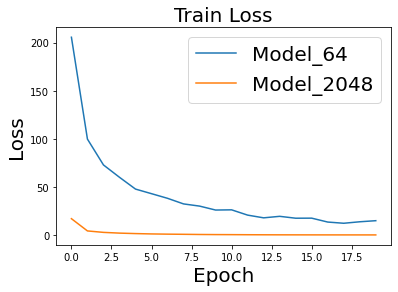

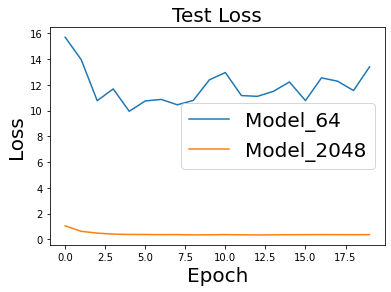

In [ ]:
#### Plot loss & accuracy ####

############################################################
plt.figure()
plt.plot(trainloss_64, label='Model_64')
plt.plot(trainloss_2048, label='Model_2048')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('Train Loss',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_3/img4.png')
plt.show()
############################################################
plt.figure()
plt.plot(testloss_64, label='Model_64')
plt.plot(testloss_2048, label='Model_2048')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('Test Loss',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_3/img5.png')
plt.show()
############################################################

In [ ]:
trainset    = torchvision.datasets.MNIST(root='./data/',train=True,download=True,transform=transforms.ToTensor())
testset     = torchvision.datasets.MNIST(root='./data/',train=False,download=True,transform=transforms.ToTensor())

trainloader = DataLoader(trainset, batch_size=2000, shuffle=True, num_workers=0)
testloader  = DataLoader(testset,  batch_size=2000, shuffle=True, num_workers=0)

device      = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
Model     = DNN_MNIST_4_layer(28*28,100,200,100,10).to(device)
criterion = nn.CrossEntropyLoss()

param_1 = Model_1e3.state_dict()
param_2 = Model_1e2.state_dict()

lr_train_loss = []
lr_train_acc  = []
lr_test_loss  = []
lr_test_acc   = []

alpha_list = np.linspace(0,1,50)

for i in range(len(alpha_list)):
    alpha = alpha_list[i]
    param_new = {}

    for key in param_1.keys():
        param_new[key] = (1-alpha)*param_1[key] + alpha*param_2[key]
    
    Model.load_state_dict(param_new)
    Model.eval()
    
    with torch.no_grad():
        train_loss = 0
        correct = 0
        for data in trainloader:
            images, labels = data
            images = (images.view(-1, 28*28)).to(device)
            labels = labels.to(device)
            outputs = Model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (pred == labels).cpu().sum()

        total    = len(trainloader.dataset)
        accuracy = 100.0*correct/total
        lr_train_loss.append(loss.detach().cpu().numpy())
        lr_train_acc.append(accuracy.detach().cpu().numpy())
        
        test_loss = 0
        correct   = 0

        for data in testloader:
            images, labels = data
            images     = (images.view(-1, 28*28)).to(device)
            labels     = labels.to(device)
            outputs    = Model(images)
            loss       = criterion(outputs, labels)
            test_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            correct += (pred == labels).cpu().sum()

        total    = len(testloader.dataset)
        accuracy = 100.0*correct/total
        lr_test_loss.append(loss.detach().cpu().numpy())
        lr_test_acc.append(accuracy.detach().cpu().numpy())

    print('alpha : ', alpha)

alpha :  0.0
alpha :  0.02040816326530612
alpha :  0.04081632653061224
alpha :  0.061224489795918366
alpha :  0.08163265306122448
alpha :  0.1020408163265306
alpha :  0.12244897959183673
alpha :  0.14285714285714285
alpha :  0.16326530612244897
alpha :  0.18367346938775508
alpha :  0.2040816326530612
alpha :  0.22448979591836732
alpha :  0.24489795918367346
alpha :  0.26530612244897955
alpha :  0.2857142857142857
alpha :  0.3061224489795918
alpha :  0.32653061224489793
alpha :  0.3469387755102041
alpha :  0.36734693877551017
alpha :  0.3877551020408163
alpha :  0.4081632653061224
alpha :  0.42857142857142855
alpha :  0.44897959183673464
alpha :  0.4693877551020408
alpha :  0.4897959183673469
alpha :  0.5102040816326531
alpha :  0.5306122448979591
alpha :  0.5510204081632653
alpha :  0.5714285714285714
alpha :  0.5918367346938775
alpha :  0.6122448979591836
alpha :  0.6326530612244897
alpha :  0.6530612244897959
alpha :  0.673469387755102
alpha :  0.6938775510204082
alpha :  0.714285714

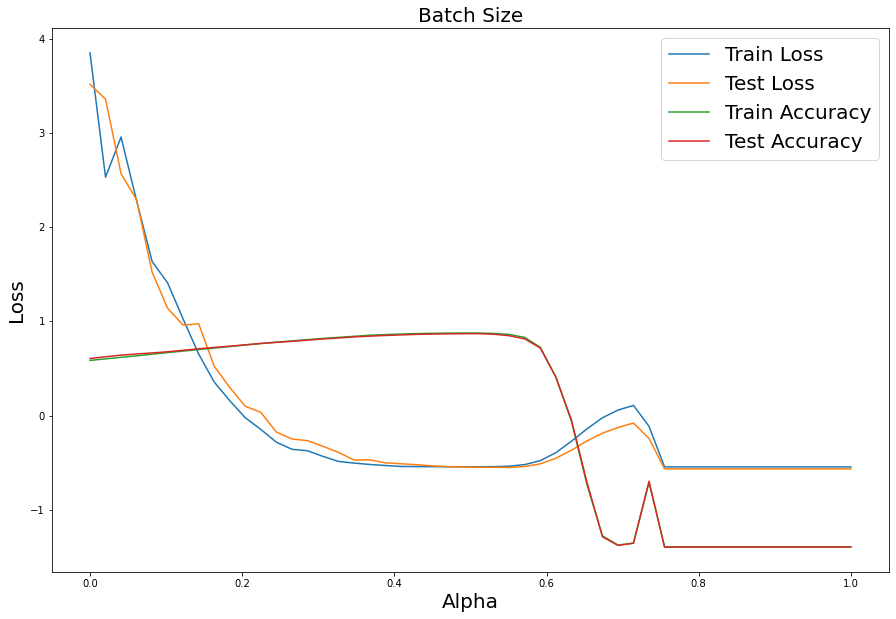

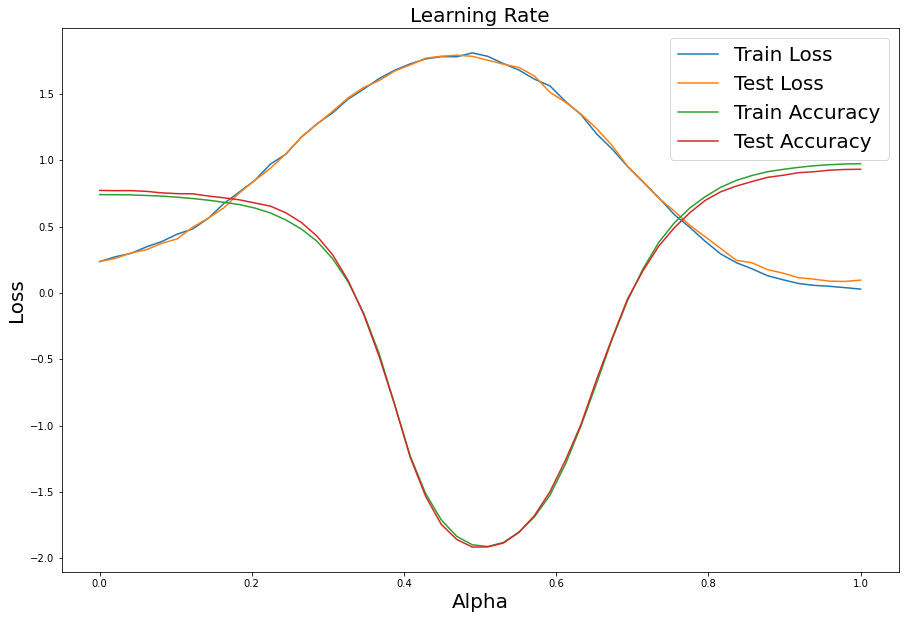

In [ ]:
####################################################################################

plt.figure(figsize=(15,10))
plt.plot(alpha_list,standardization(batch_train_loss), label='Train Loss')
plt.plot(alpha_list,standardization(batch_test_loss),label='Test Loss')
plt.plot(alpha_list,standardization(batch_train_acc),label='Train Accuracy')
plt.plot(alpha_list,standardization(batch_test_acc),label='Test Accuracy')
plt.xlabel('Alpha',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('Batch Size',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_3/img6.png')
plt.show()
####################################################################################
plt.figure(figsize=(15,10))
plt.plot(alpha_list,(lr_train_loss), label='Train Loss')
plt.plot(alpha_list,(lr_test_loss), label='Test Loss')
plt.plot(alpha_list,standardization(lr_train_acc), label='Train Accuracy')
plt.plot(alpha_list,standardization(lr_test_acc), label='Test Accuracy')
plt.xlabel('Alpha',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title('Learning Rate',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('/content/drive/MyDrive/Deep_Learning_HW1/P1/images/Part_3/img7.png')
plt.show()
####################################################################################


## Flatness v.s. Generalization - part2

In [ ]:
####################################################################################
[_,trainloss_1, testloss_1, accuracy_1, _, F_1] = train_MNIST(model_name=DNN_MNIST_4_layer(28*28,10,20,10,10), Batch=10)
####################################################################################
[_,trainloss_2, testloss_2, accuracy_2, _, F_2] = train_MNIST(model_name=DNN_MNIST_4_layer(28*28,10,20,10,10), Batch=50)
####################################################################################
[_,trainloss_3, testloss_3, accuracy_3, _, F_3] = train_MNIST(model_name=DNN_MNIST_4_layer(28*28,10,20,10,10), Batch=100)
####################################################################################
[_,trainloss_4, testloss_4, accuracy_4, _, F_4] = train_MNIST(model_name=DNN_MNIST_4_layer(28*28,10,20,10,10), Batch=200)
####################################################################################
[_,trainloss_5, testloss_5, accuracy_5, _, F_5] = train_MNIST(model_name=DNN_MNIST_4_layer(28*28,10,20,10,10), Batch=1000)
####################################################################################

Datasdet Information : 
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
0/20 Test set: Average loss: 5353.0701/500.2074, Accuracy: 8440/10000 (84.40%) lr=0.1
1/20 Test set: Average loss: 4332.4709/430.3211, Accuracy: 8684/10000 (86.84%) lr=0.1
2/20 Test set: Average loss: 4098.3450/360.0787, Accuracy: 9011/10000 (90.11%) lr=0.1
3/20 Test set: Average loss: 3891.6362/371.8152, Accuracy: 8926/10000 (89.26%) lr=0.1
4/20 Test set: Average loss: 3898.5599/343.0944, Accuracy: 9014/10000 (90.14%) lr=0.1
5/20 Test set: Average loss: 3768.4219/322.9466, Accuracy: 9067/10000 (90.67%) lr=0.1
6/20 Test set: Average loss: 3746.4458/350.2229, Accuracy: 9045/10000 (90.45%) lr=0.1
7/20 Test set: Average loss: 3693.5046/415.3360, Accuracy: 8746/10000 (87.46%) lr=0.1
8/20 Test set: Average loss: 3751.5058/315.7190, Accuracy: 9091/10000 (90.91%) lr=0.1
9/20 Test set: Average lo